In [1]:
import numpy as np
from PIL import Image
import datetime
import matplotlib.pyplot as plt
from torchvision.models import vgg16_bn
import warnings
import torch.cuda
from torch_snippets import *
from torchvision import transforms
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import cv2


%matplotlib inline
warnings.filterwarnings("ignore")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class BaseDataProvider(object):
    channels = 1
    n_class = 2

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            if label.dtype != 'bool':
                label = label.astype(np.bool_)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Post-processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

In [3]:
class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

In [4]:
class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

In [5]:
def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):
    """
    Generate synthetic images and labels for object detection or segmentation tasks.

    Parameters:
    :param nx: Width of the image.
    :param ny: Height of the image.
    :param cnt: Number of objects (circles) to generate in the image.
    :param r_min: Minimum radius of objects.
    :param r_max: Maximum radius of objects.
    :param border: Minimum distance between object centers and the image borders.
    :param sigma: Standard deviation for adding random noise to the image.
    :param rectangles: If True, generate random rectangles in addition to circles.

    Returns:
    tuple: A tuple containing the generated image and label.
        - If `rectangles` is False:
            - :return image (numpy.ndarray): A synthetic image with intensity values representing objects.
            - :return label (numpy.ndarray): A binary label where object regions are indicated by `label[..., 1]`.

        - If `rectangles` is True:
            - :return image (numpy.ndarray): A synthetic image with intensity values representing objects.
            - :return label (numpy.ndarray): A multi-class label where:
                - `label[..., 0]` indicates background regions.
                - `label[..., 1]` indicates circle regions.
                - `label[..., 2]` indicates rectangle regions.

    Example Usage:
    image, label = create_image_and_label(256, 256, cnt=5, r_min=10, r_max=30, rectangles=False)

    image, label = create_image_and_label(512, 512, cnt=10, r_min=5, r_max=50, rectangles=True)
    """
    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=np.bool_)
    mask = np.zeros((nx, ny), dtype=np.bool_)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1

    if rectangles:
        mask = np.zeros((nx, ny), dtype=np.bool_)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            m = np.zeros((nx, ny), dtype=bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h

        label[mask, 2] = 1

        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)

    if rectangles:
        return image, label
    else:
        return image, label[..., 1]

In [6]:
def to_rgb(img):
    """
    Converts a single-channel image to a three-channel RGB image.

    Parameters:
    :param img: Input single-channel image represented as a NumPy two-dimensional array.

    Returns:
    :return rgb: A three-channel RGB image represented as a NumPy three-dimensional array, where each channel
    (red, green, blue) is presented in a separate matrix.

    Example Usage:
    img = load_grayscale_image('input.png')
    rgb_img = to_rgb(img)
    display_rgb_image(rgb_img)
    """
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb


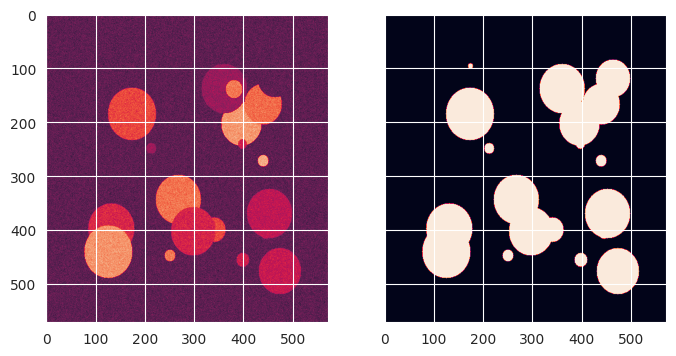

In [7]:
nx = 572
ny = 572

generator = GrayScaleDataProvider(nx, ny, cnt=20)

x_test, y_test = generator(1)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")

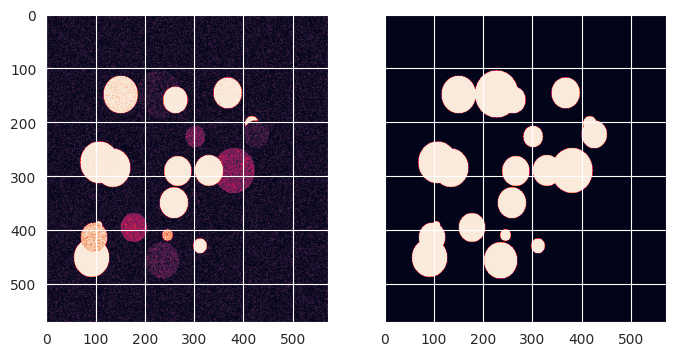

In [8]:
generator = RgbDataProvider(nx, ny, cnt=20)

x_test, y_test = generator(1)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")

In [9]:
x_test[0, ... , 0].mean(),x_test[0, ... , 1].mean(),x_test[0, ... , 2].mean()

(0.1501595760695432, 0.986923012245932, 0.9522056906191912)

In [10]:
x_test[0, ... , 0].std(),x_test[0, ... , 1].std(),x_test[0, ... , 2].std()

(0.2849735537560819, 0.10687187095351666, 0.18783480519907358)

In [11]:
y_test[0,...,1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
y_test[0,...,0]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [13]:
y_test.shape

(1, 572, 572, 2)

In [14]:
x_test.shape

(1, 572, 572, 3)

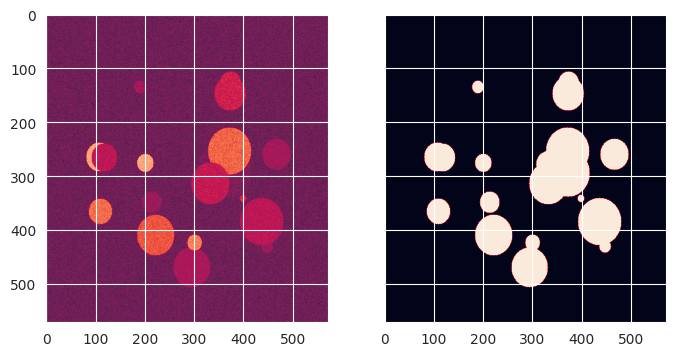

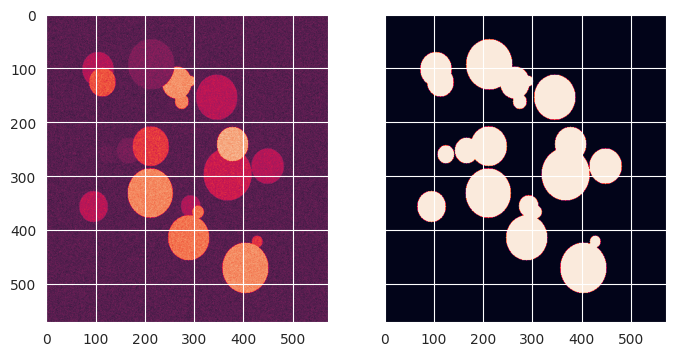

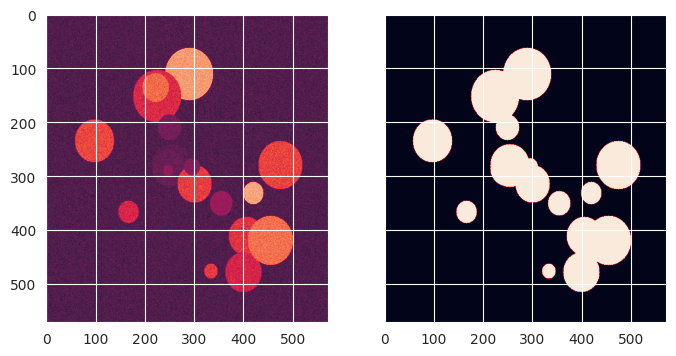

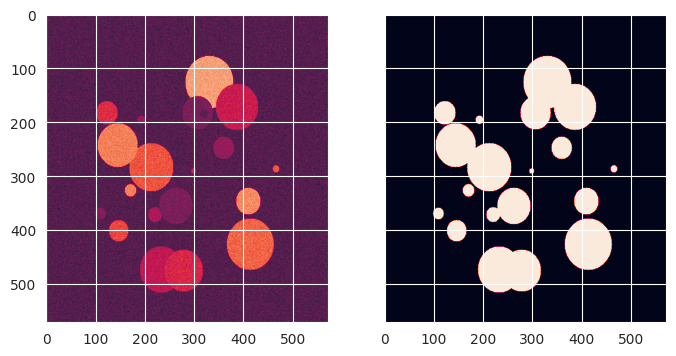

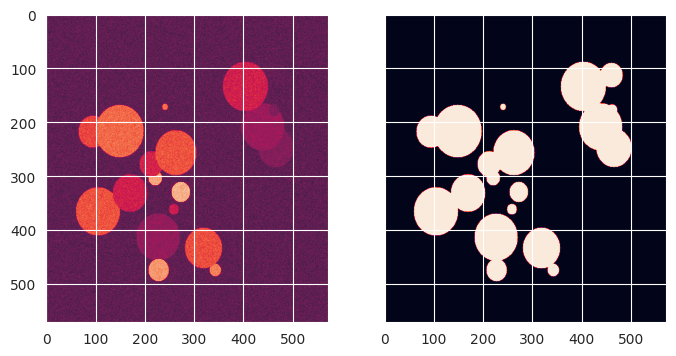

In [15]:
nx = 572
ny = 572

generator = GrayScaleDataProvider(nx, ny, cnt=20)

x_test, y_test = generator(5)

for i in range(len(x_test)):
    fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
    ax[0].imshow(x_test[i,...,0], aspect="auto")
    ax[1].imshow(y_test[i,...,1], aspect="auto")

In [16]:
transforms_imgs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [17]:
class SegData(Dataset):
    def __init__(self, nx, ny, cnt, bath_size):
        self.generator = RgbDataProvider(nx, ny, cnt=cnt)
            
        self.images, self.masks = self.generator(bath_size)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, ix):
        image = self.images[ix]
        image = cv2.resize(image, (224, 224))
        mask = self.masks[ix][...,1]
        mask = cv2.resize(mask, (224, 224))
        return image, mask
    
    def choose(self):
        return self[randint(len(self))]
    
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([transforms_imgs(im.copy())[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [18]:
trn_ds = SegData(nx=572, ny=572, cnt=20, bath_size=50)
val_ds = SegData(nx=572, ny=572, cnt=20, bath_size=10)
trn_dl = DataLoader(trn_ds, batch_size=10, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=True, collate_fn=val_ds.collate_fn)

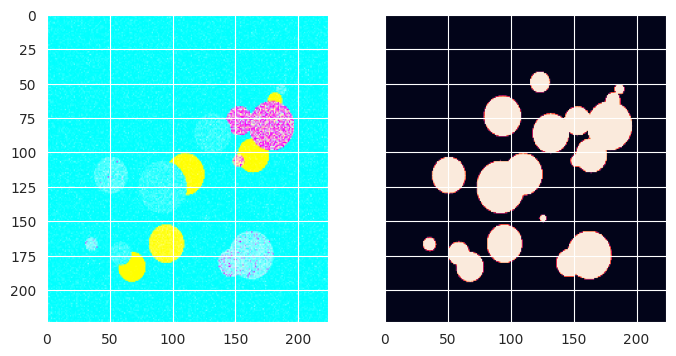

In [19]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(trn_ds[12][0], aspect="auto")
ax[1].imshow(trn_ds[12][1], aspect="auto")

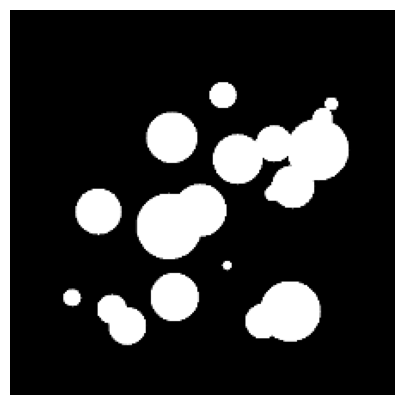

In [20]:
show(trn_ds[12][1])

In [21]:
def convolve(in_channels, out_channels):
    """
    Create a convolutional layer with batch normalization and ReLU activation.

    Parameters:
    :param in_channels: Number of input channels (e.g., for an RGB image, in_channels = 3).
    :param out_channels: Number of output channels (number of filters).

    Returns:
    :return torch.nn.Sequential: A sequential container for the convolutional layer with batch normalization and ReLU activation.

    Example Usage:
    conv_layer = convolve(3, 64)
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True)
    )

In [22]:
def up_convolve(in_channels, out_channels):
    """
    Create an up-convolutional layer with ReLU activation.

    Parameters:
    :param in_channels: Number of input channels.
    :param out_channels: Number of output channels.

    Returns:
    :return torch.nn.Sequential: A sequential container for the up-convolutional layer with ReLU activation.

    Example Usage:
    upconv_layer = up_convolve(64, 32)
    """

    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2),
        nn.ReLU(inplace = True)
    )

In [23]:
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=2):
        super().__init__()
        
        self.encoder = vgg16_bn(pretrained=pretrained).features
        
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])
        
        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = convolve(512, 1024)
        
        self.up_conv6 = up_convolve(1024, 512)
        self.conv6 = convolve(512 + 512, 512)
        self.up_conv7 = up_convolve(512, 256)
        self.conv7 = convolve(256 + 512, 256)
        self.up_conv8 = up_convolve(256, 128)
        self.conv8 = convolve(128 + 256, 128)
        self.up_conv9 = up_convolve(128, 64)
        self.conv9 = convolve(64 + 128, 64)
        self.up_conv10 = up_convolve(64, 32)
        self.conv10 = convolve(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        
        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)
        
        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)
        
        x = self.conv11(x)

        return x

In [24]:
ce = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):
    """
    Compute the loss for a U-Net model using Cross-Entropy Loss and calculate accuracy.

    Parameters:
    :param preds: Model predictions, typically the output of a U-Net model.
    :param targets: Ground truth labels or target values.

    Returns:
    tuple: A tuple containing the cross-entropy loss and accuracy.
        - :return Cross-Entropy Loss: A scalar value representing the loss between predictions and targets.
        - :return Accuracy: A scalar value representing the classification accuracy.

    Example Usage:
    predictions = unet_model(input_data)
    ce_loss, accuracy = UnetLoss(predictions, ground_truth_labels)
    """
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [25]:
def train_batch(model, data, optimizer, criterion):
    """
    Train a neural network model on a single batch of training data.

    Parameters:
    :param model: The neural network model to be trained.
    :param data: A tuple containing input data (ims) and target data (ce_masks).
    :param optimizer: The optimizer used for updating the model's parameters.
    :param criterion: A loss function that computes the training loss and accuracy.

    Returns:
    tuple: A tuple containing the training loss and accuracy for the batch.
        - :return Training Loss (float): The loss computed during training.
        - :return Training Accuracy (float): The classification accuracy on the training data.

    Example Usage:
    batch_data = get_training_batch()
    loss, accuracy = train_batch(neural_net, batch_data, optimizer, UnetLoss)
    """
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    """
    Validate a neural network model on a single batch of validation data.

    Parameters:
    :param model: The neural network model to be validated.
    :param data: A tuple containing input data (ims) and target data (masks).
    :param criterion: A loss function that computes the validation loss and accuracy.

    Returns:
    tuple: A tuple containing the validation loss and accuracy for the batch.
        - :return Validation Loss (float): The loss computed during validation.
        - :return Validation Accuracy (float): The classification accuracy on the validation data.

    Example Usage:
    validation_data = get_validation_batch()
    loss, accuracy = validate_batch(neural_net, validation_data, UnetLoss)
    """
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [26]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 50

In [27]:
def train(model, criterion, optimizer, train_data, n_epochs=20):
    """
    Train a machine learning or deep learning model using the specified criterion and optimizer.

    Parameters:
    :param model: The model to be trained.
    :param criterion: The loss criterion used for training (e.g., nn.CrossEntropyLoss).
    :param optimizer: The optimizer used for model parameter updates (e.g., torch.optim.SGD).
    :param train_data: The training dataset or data loader.
    :param n_epochs: The number of training epochs. Defaults to 20.

    Example:
        model = MyModel()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

        train(model, criterion, optimizer, train_data, n_epochs=20)
    """
    log = Report(n_epochs)
    for ex in range(n_epochs):
        N = len(train_data)
        for bx, data in enumerate(train_data):
            loss, acc = train_batch(model, data, optimizer,criterion)
            log.record(ex+(bx+1)/N, trn_loss=loss,trn_acc=acc, end='\r')
    
        N = len(val_dl)
        for bx, data in enumerate(val_dl):
            loss, acc = validate_batch(model, data, criterion)
            log.record(ex+(bx+1)/N, val_loss=loss,val_acc=acc, end='\r')
            
        log.report_avgs(ex+1)
    
    log.plot_epochs(['trn_loss','val_loss'])

EPOCH: 1.000  trn_loss: 0.575  val_acc: 0.951  val_loss: 0.597  trn_acc: 0.766  (3.48s - 170.29s remaining)
EPOCH: 2.000  trn_loss: 0.421  val_acc: 0.961  val_loss: 0.526  trn_acc: 0.963  (6.24s - 149.69s remaining)
EPOCH: 3.000  trn_loss: 0.365  val_acc: 0.810  val_loss: 0.556  trn_acc: 0.974  (8.98s - 140.66s remaining)
EPOCH: 4.000  trn_loss: 0.314  val_acc: 0.371  val_loss: 1.257  trn_acc: 0.984  (11.72s - 134.77s remaining)
EPOCH: 5.000  trn_loss: 0.278  val_acc: 0.630  val_loss: 0.780  trn_acc: 0.984  (14.48s - 130.33s remaining)
EPOCH: 6.000  trn_loss: 0.246  val_acc: 0.698  val_loss: 0.744  trn_acc: 0.988  (17.24s - 126.42s remaining)
EPOCH: 7.000  trn_loss: 0.221  val_acc: 0.648  val_loss: 0.801  trn_acc: 0.989  (19.99s - 122.80s remaining)
EPOCH: 8.000  trn_loss: 0.197  val_acc: 0.680  val_loss: 0.739  trn_acc: 0.991  (22.75s - 119.45s remaining)
EPOCH: 9.000  trn_loss: 0.179  val_acc: 0.864  val_loss: 0.392  trn_acc: 0.991  (25.52s - 116.24s remaining)
EPOCH: 10.000  trn_los

100%|██████████| 151/151 [00:00<00:00, 14856.67it/s]


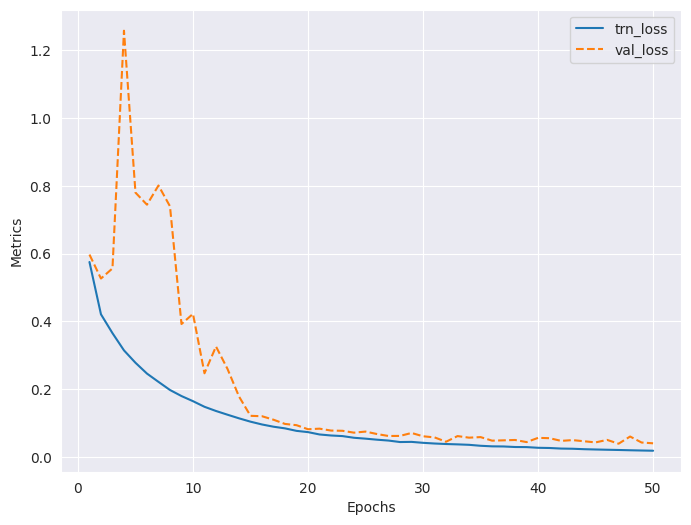

In [28]:
train(model=model,criterion=criterion,optimizer=optimizer,train_data=trn_dl,n_epochs=n_epochs)

In [29]:
def save_model(model,optimizer,path='../models/'):
    """
    Save a PyTorch model and its optimizer's state to a file with a timestamped filename.

    Parameters:
    :param model: The PyTorch model to be saved.
    :param optimizer: The optimizer used for training the model.
    :param path: The directory path where the model checkpoint will be saved.
            Defaults to '../models/'.
            
    Example:
        save_model(neural_net, optimizer, path='../models/')
    """
    timestamp = datetime.now().strftime("%d-%m-%Y_%H:%M:%S")
    file_name = f'UNet-model_{timestamp}.pth'
    file_path = os.path.join(path, file_name)
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'model_architecture': model,
    }
    
    torch.save(checkpoint,file_path)    

In [30]:
def load_model(path,optimizer = None):
    """
    Load a PyTorch model and, optionally, its optimizer from a saved checkpoint file.

    Parameters:
    :param path: The file path to the saved model checkpoint.
    :param optimizer: The optimizer to use for the loaded model.
            If provided, the optimizer's state is loaded from the checkpoint.
            Defaults to None.

    Returns:
        :return tuple or torch.nn.Module: A tuple containing the loaded PyTorch model and optimizer if available.
        If the optimizer is not provided, it returns only the loaded model.

    Example:
        loaded_model = load_model('path/to/model_checkpoint.pth')
        
        optimizer = torch.optim.SGD  # Replace with your actual optimizer
        loaded_model, loaded_optimizer = load_model('path/to/model_checkpoint.pth', optimizer=optimizer)
    """
    checkpoint = torch.load(path)
    model = checkpoint['model_architecture']
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None:
        optimizer = optimizer(model.parameters())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return model.to(device), optimizer
    
    return model.to(device)

In [31]:
save_model(model,optimizer)

In [32]:
def generate_mask(model,images = SegData):
    """
    Generate and visualize masks using a segmentation model.
    
    Parameters:
    :param model: The segmentation model for generating masks.
    :param images: A dataset containing images and ground truth masks.
            Defaults to SegData.

    Example:
        generate_mask(segmentation_model, images=custom_dataset)
    """
    for i in range(len(images)):
        image, mask = images[i]
        
        image = transforms_imgs(image.copy())[None].float().to(device)
        mask = torch.Tensor(mask[None]).long().to(device)
        
        _mask=model(image)
        _, _mask = torch.max(_mask, dim=1)
        
        subplots([image[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0],\
        _mask.permute(1,2,0).detach().cpu()[:,:,0]],nc=3,titles=['Original image','Original mask',\
        'Predicted mask'])
        

In [33]:
images = SegData(nx=572,ny=572,cnt=20,bath_size=10)

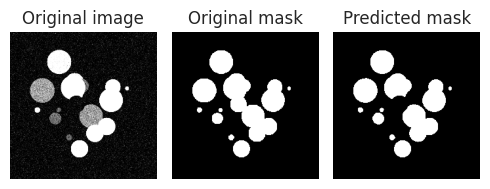

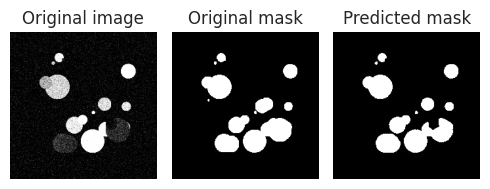

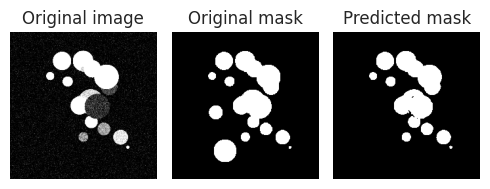

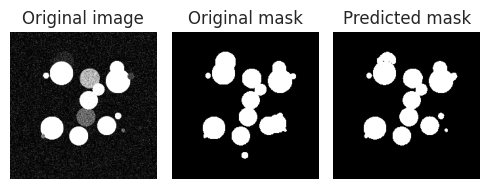

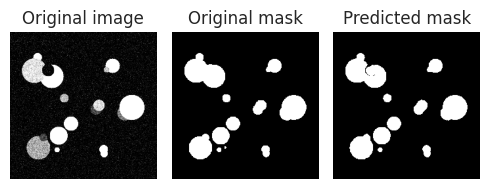

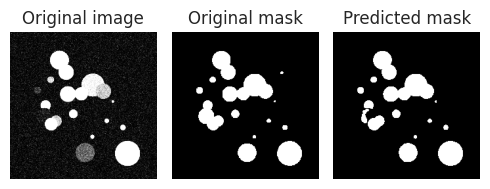

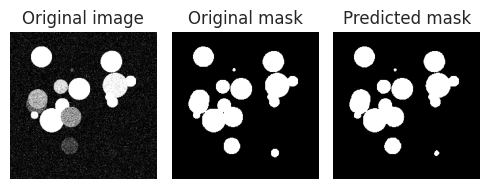

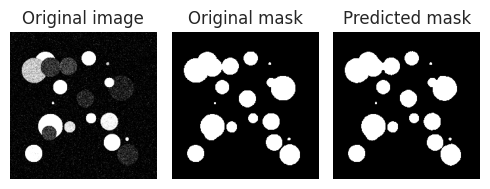

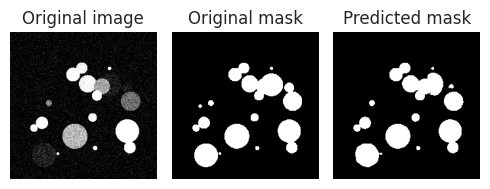

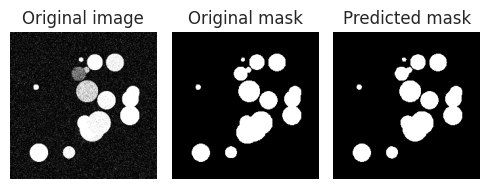

In [34]:
generate_mask(model,images)